# Tests

## Imports and stuff

In [1]:
import sys

def append_path(s):
    if s in sys.path:
        return
    sys.path.append(s)

append_path("..")
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
import torch
from torch import Tensor


In [3]:
import ml_lib


## Datasets

In [4]:
from ml_lib.datasets import register as dataset_register, transform_register

In [5]:
dataset0 = dataset_register["Torus4D"](1000)

In [6]:
dataset1 = transform_register["CacheTransform"](dataset0)

In [7]:
dataset1[0]

tensor([[0.3894, 0.9225, 0.7859, 0.6132]])

In [8]:
dataset2 = transform_register["RenameTransform"](dataset1, {"_": "x"})
dataset2[0]

datapoint(x=tensor([[0.3894, 0.9225, 0.7859, 0.6132]]))

In [9]:
dataset3 = transform_register["RenameTransform"](dataset2, {"x": "x", 0:"y"})
dataset3[0]

datapoint(x=tensor([[0.3894, 0.9225, 0.7859, 0.6132]]), y=tensor([[0.3894, 0.9225, 0.7859, 0.6132]]))

In [10]:
normalize = lambda x : x / x.norm()
dataset4 = transform_register["MultipleFunctionTransform"](dataset3, {"x": (normalize, "x"), "gt": (lambda x:x, "y")})
dataset4[0]

datapoint(x=tensor([[0.2756, 0.6529, 0.5562, 0.4340]]), gt=tensor([[0.3894, 0.9225, 0.7859, 0.6132]]))

great!

## Environments

In [11]:
from ml_lib.environment import Environment, Scope, scopevar_of_str, str_of_scopevar, HierarchicEnvironment, ScopedEnvironment

In [12]:
scopevar_of_str("a/b/c")

(('a', 'b'), 'c')

In [13]:
str_of_scopevar(('a', 'b'), 'c')

'a/b/c'

In [14]:
env = Environment()

In [15]:
env

Environment(defaultdict(<class 'dict'>, {'_ipython_canary_method_should_not_exist_': {}, '_ipython_display_': {}, '_repr_mimebundle_': {}}))

In [16]:
env.record("hello", 1)

In [17]:
env.data

defaultdict(dict,
            {'_ipython_canary_method_should_not_exist_': {},
             '_ipython_display_': {},
             '_repr_mimebundle_': {},
             '_repr_html_': {},
             '_repr_markdown_': {},
             '_repr_svg_': {},
             '_repr_png_': {},
             '_repr_pdf_': {},
             '_repr_jpeg_': {},
             '_repr_latex_': {},
             '_repr_json_': {},
             '_repr_javascript_': {},
             'hello': {(): 1}})

In [18]:
env.record("world", 4, ("some", "scope"))
env.data

defaultdict(dict,
            {'_ipython_canary_method_should_not_exist_': {},
             '_ipython_display_': {},
             '_repr_mimebundle_': {},
             '_repr_html_': {},
             '_repr_markdown_': {},
             '_repr_svg_': {},
             '_repr_png_': {},
             '_repr_pdf_': {},
             '_repr_jpeg_': {},
             '_repr_latex_': {},
             '_repr_json_': {},
             '_repr_javascript_': {},
             'hello': {(): 1},
             'world': {('some', 'scope'): 4}})

In [19]:
env.get("hello")

1

In [20]:
env.get("world")

4

In [21]:
#import pdb; pdb.set_trace()
env.get("world", scope=("some",))

4

In [22]:
env.get("world", scope=("soe",))

In [23]:
hier_env = HierarchicEnvironment(parent=env)

In [24]:
hier_env.record("world", 2, ("some",))
hier_env.get("world", scope=("some",))


2

In [25]:
hier_env.get("world", scope=("some","scope"))


4

In [26]:
def f(world, hello=6, magic=3):
    print(world, hello, magic)
    return 1

In [27]:
hier_env.run_function(f)

2 1 3


1

## Model

In [28]:
from ml_lib.models import Model, Supervised, Hyperparameter
from ml_lib.models.layers import MLP
class SimpleMLPModel(Supervised):

    dimensions: Hyperparameter[list[int]]

    inner: MLP

    def __setup__(self):
        self.inner = MLP(*self.dimensions, batchnorm=False)

    def forward(self, x):
        return self.inner(x)

    def loss_fun(self, x, gt):
        return (x - gt).square().sum()

model = SimpleMLPModel(dimensions=[4, 5, 10, 4, 4])
print(model)
print(torch.nn.Module.__repr__(model))

SimpleMLPModel(
    dimensions=[4, 5, 10, 4, 4],
)
SimpleMLPModel(
  (inner): MLP(
    (linear_0): Linear(in_features=4, out_features=5, bias=True)
    (activation_0): ReLU()
    (linear_1): Linear(in_features=5, out_features=10, bias=True)
    (activation_1): ReLU()
    (linear_2): Linear(in_features=10, out_features=4, bias=True)
    (activation_2): ReLU()
    (linear_3): Linear(in_features=4, out_features=4, bias=True)
  )
)


## Training

In [29]:
from ml_lib.models import Model
from ml_lib.pipeline import Trainer
from ml_lib.pipeline.training_hooks import TqdmHook, LoggerHook, CurveHook
from torch.utils.data import DataLoader

In [30]:
loader = DataLoader(dataset4, batch_size=None, shuffle=True)

In [31]:
next(iter(loader))

datapoint(x=tensor([[-0.5940,  0.3736, -0.2314,  0.6738]]), gt=tensor([[-0.8407,  0.5288, -0.3275,  0.9535]]))

In [32]:
import logging; logging.basicConfig(level=logging.INFO, force=True)

curve = CurveHook()

trainer = Trainer(model, loader, n_epochs = 4, device="cpu",
    step_hooks = [ 
        TqdmHook(),
        LoggerHook(interval=10),
        curve
    ]
                 
                 )
trainer.train()

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:loss= 2.938366651535034, 
INFO:root:loss= 3.0411834716796875, 
INFO:root:loss= 1.160255789756775, 
INFO:root:loss= 2.664428949356079, 
INFO:root:loss= 2.1791725158691406, 
INFO:root:loss= 3.444607973098755, 
INFO:root:loss= 4.003042697906494, 
INFO:root:loss= 1.9195407629013062, 
INFO:root:loss= 2.8219783306121826, 
INFO:root:loss= 2.143404960632324, 
INFO:root:loss= 1.4969561100006104, 
INFO:root:loss= 0.7482514977455139, 
INFO:root:loss= 3.000108480453491, 
INFO:root:loss= 1.2386534214019775, 
INFO:root:loss= 2.4637484550476074, 
INFO:root:loss= 2.170470714569092, 
INFO:root:loss= 2.9631216526031494, 
INFO:root:loss= 2.9610157012939453, 
INFO:root:loss= 2.5379252433776855, 
INFO:root:loss= 2.1955690383911133, 
INFO:root:loss= 1.718267560005188, 
INFO:root:loss= 1.3583260774612427, 
INFO:root:loss= 1.346670150756836, 
INFO:root:loss= 1.1337165832519531, 
INFO:root:loss= 1.79925537109375, 
INFO:root:loss= 0.887220561504364, 
INFO:root:loss= 0.7949179410934448, 
INFO:root:loss

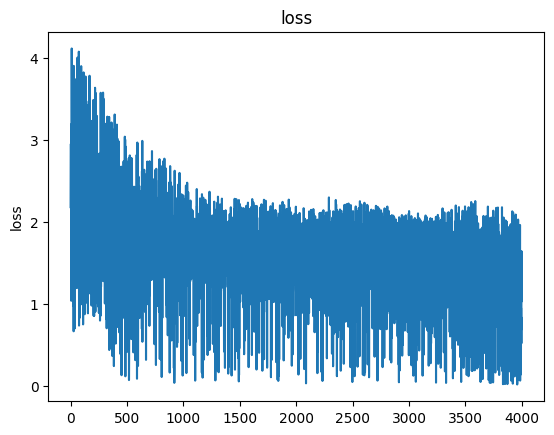

In [33]:
curve.draw()

In [34]:
pip install matplotlib


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
